## Analyzing Voting Patterns and Factors Influencing Consensus at the United Nations General Assembly

### Yunong Xue

## install & import 

In [1]:
# !pip install pandasql
# !pip install linearmodels

In [2]:
# Importing essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importing SQL related library
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

# Importing Statsmodels libraries for statistical modeling
from scipy import stats
import statsmodels.api as sm
from linearmodels.panel import PanelOLS


## Data Import and Cleaning

#### Trade Data

In [3]:
# Loading the trade data and storing it in a DataFrame
trade_data = pd.read_csv('trade_1988_2021.csv')

# Renaming the 'TradeValue in 1000 USD' column to 'TradeValue' for simplicity
trade_data.rename(columns={'TradeValue in 1000 USD': 'TradeValue'}, inplace=True)

# Check null values
trade_data.isna().sum()

ReporterISO3      0
ReporterName      0
PartnerISO3       0
PartnerName       0
Year              0
TradeFlowName     0
TradeValue       68
dtype: int64

In [4]:
# drop NA values and check
trade_data.dropna(inplace=True)
trade_data.isna().sum()

ReporterISO3     0
ReporterName     0
PartnerISO3      0
PartnerName      0
Year             0
TradeFlowName    0
TradeValue       0
dtype: int64

In [5]:
# Removing rows with 'WLD' (World) as PartnerISO3
trade_data = trade_data.drop(trade_data[trade_data['PartnerISO3'] == 'WLD'].index)
trade_data = trade_data.drop(trade_data[trade_data['ReporterISO3'] == 'WLD'].index)

# Removing rows with 'UNS' (Unspecified) as PartnerISO3
trade_data = trade_data.drop(trade_data[trade_data['PartnerISO3'] == 'UNS'].index)
trade_data = trade_data.drop(trade_data[trade_data['ReporterISO3'] == 'UNS'].index)

In [6]:
# SQL query to obtain import values by joining the trade_data table with itself
query_get_import_value = '''
    SELECT trade1.ReporterISO3, trade1.PartnerISO3, trade1.Year, trade2.TradeValue AS Import_Value
    FROM trade_data AS trade1
    LEFT JOIN trade_data AS trade2
    ON (trade2.ReporterISO3 = trade1.PartnerISO3) AND (trade2.PartnerISO3 = trade1.ReporterISO3) AND (trade1.Year = trade2.Year)
'''

# Executing the SQL query and storing the result in a DataFrame
import_value_table = pysqldf(query_get_import_value)


In [7]:
# SQL query to calculate the total export value for each country and year
query_sum_exp = '''
    SELECT ReporterISO3 AS ISO3, Year, SUM(TradeValue) AS Total_Export
    FROM trade_data
    GROUP BY ReporterISO3, Year
'''

# Executing the SQL query and storing the result in a DataFrame
export_table = pysqldf(query_sum_exp)

In [8]:
# SQL query to join trade_data, export_table, and import_value_table
query_join_trade_tables = '''
    SELECT T.ReporterISO3, T.PartnerISO3, T.Year, T.TradeValue AS Export_Value,
           IM.Import_Value, TX1.Total_Export as Total_Exp_Iso1, TX2.Total_Export as Total_Exp_Iso2
    FROM trade_data AS T
    LEFT JOIN export_table AS TX1
    ON (T.ReporterISO3 = TX1.ISO3) AND (T.Year = TX1.Year)
    LEFT JOIN export_table AS TX2
    ON (T.PartnerISO3 = TX2.ISO3) AND (T.Year = TX2.Year)
    LEFT JOIN import_value_table AS IM
    ON (T.ReporterISO3 = IM.ReporterISO3) AND (T.PartnerISO3 = IM.PartnerISO3) AND (T.year = IM.Year)
'''

# Executing the SQL query and storing the result in a DataFrame
trade_final = pysqldf(query_join_trade_tables)

In [9]:
# Calculating import and export percentages for each trade relationship
trade_final['Exp_Pct_Avg'] = 0.5 * (trade_final['Export_Value']/trade_final['Total_Exp_Iso1'] \
+ trade_final['Import_Value']/trade_final['Total_Exp_Iso2'])

In [10]:
# Check null value again
trade_final.isna().sum()

ReporterISO3           0
PartnerISO3            0
Year                   0
Export_Value           0
Import_Value      223409
Total_Exp_Iso1         0
Total_Exp_Iso2    142843
Exp_Pct_Avg       223409
dtype: int64

In [11]:
# Fill null values with 0.
trade_final.fillna(0, inplace=True) 
## null value resulted from "left join" indicates country1 did not have import from country 2 that year
## fill NA with 0 should therefore be reasonable

In [12]:
trade_final.head()

,ReporterISO3,PartnerISO3,Year,Export_Value,Import_Value,Total_Exp_Iso1,Total_Exp_Iso2,Exp_Pct_Avg
0,AFG,SWE,2017,86.752,13958.154,831859.266,1.496390e+08,0.000099
1,AFG,JOR,2018,2796.481,974.457,875181.032,6.584095e+06,0.001672
2,AFG,JOR,2017,3100.187,1533.252,831859.266,6.301724e+06,0.001985
3,AFG,ITA,2018,279.918,13227.168,875181.032,5.217846e+08,0.000173
4,AFG,ITA,2017,416.642,18783.400,831859.266,4.883615e+08,0.000270


#### Affinity Score

I commented below part because it would take too long time to run. Later I'll directly load the exported data which I cleaned with the below code.

In [13]:
# Loading the agreement scores data and storing it in a DataFrame
# agreement_scores = pd.read_csv('AgreementScoresAll_Jun2022.csv')


In [14]:
# Loading the votes data and storing it in a DataFrame
# votes = pd.read_csv('Votes.csv')

# Extracting unique country ccode-ISO pairs and storing them in a new DataFrame
# country_code_pair = votes[['ccode', 'Country']].drop_duplicates(subset=['ccode'], keep='first')


In [15]:
# Filtering the agreement_scores DataFrame to keep records with 'year' greater than 1987
# agreement_scores = agreement_scores.loc[agreement_scores['year'] > 1987]


In [16]:
# def ccode_iso(ccode):
#     """
#     Function to convert 'ccode' to corresponding ISO country code using country_code dataframe
    
#     Args:
#     ccode (int): The 'ccode' to be converted.

#     Returns:
#     str: The corresponding ISO country code.
#     """
#     return country_code_pair[country_code_pair['ccode'] == ccode].iloc[:, 1].values[0]


In [17]:
# Creating a copy of the agreement_scores DataFrame to add ISO codes
# agreement_scores_with_iso = agreement_scores.copy()

# Adding 'iso1' and 'iso2' columns by converting 'ccode1' and 'ccode2' to ISO country codes
# agreement_scores_with_iso['iso1'] = agreement_scores_with_iso['ccode1'].apply(ccode_iso)
# agreement_scores_with_iso['iso2'] = agreement_scores_with_iso['ccode2'].apply(ccode_iso)


In [18]:
# Saving the agreement_scores_with_iso DataFrame to a CSV file
# agreement_scores_with_iso.to_csv('agreement_scores_with_iso.csv')
# comment all the ones above out because we already saved this into csv file

In [19]:
# read the file
agreement_scores_with_iso = pd.read_csv('agreement_scores_with_iso.csv')

In [20]:
agreement_scores_with_iso.isna().sum()
# neglect the missing values because we are not using those columns

Unnamed: 0              0
Unnamed: 0.1            0
session.x               0
ccode1                  0
ccode2                  0
agree                   0
year                    0
IdealPointAll.x       127
NVotesAll.x           127
IdealPointAll.y       127
NVotesAll.y           127
IdealPointDistance    254
iso1                    0
iso2                    0
dtype: int64

In [21]:
# drop invalid columns
agreement_scores_with_iso.drop(columns=['Unnamed: 0', 'Unnamed: 0.1','ccode1','ccode2'],inplace=True)
agreement_scores_with_iso.head(5)

,session.x,agree,year,IdealPointAll.x,NVotesAll.x,IdealPointAll.y,NVotesAll.y,IdealPointDistance,iso1,iso2
0,43,0.556818,1988,3.079959,133.0,1.585116,133.0,1.494843,USA,CAN
1,43,0.268000,1988,3.079959,133.0,0.223987,128.0,2.855972,USA,BHS
2,43,0.206767,1988,3.079959,133.0,-1.352824,135.0,4.432783,USA,CUB
3,43,0.260163,1988,3.079959,133.0,-0.039816,126.0,3.119775,USA,HTI
4,43,0.274590,1988,3.079959,133.0,0.287246,125.0,2.792713,USA,DOM


#### Country Similarity

In [22]:
# Loading the country similarity data and storing it in a DataFrame
country_similarity = pd.read_excel('dist_cepii.xls')
country_similarity.head()

,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,curcol,col45,smctry,dist,distcap,distw,distwces
0,ABW,ABW,0,0,0,0,0,0,0,0,5.225315,5.225315,25.09354,23.04723
1,ABW,AFG,0,0,0,0,0,0,0,0,13257.810000,13257.810000,13168.22,13166.37
2,ABW,AGO,0,0,0,0,0,0,0,0,9516.913000,9516.913000,9587.316,9584.193
3,ABW,AIA,0,0,1,0,0,0,0,0,983.268200,983.268200,976.8974,976.8916
4,ABW,ALB,0,0,0,0,0,0,0,0,9091.742000,9091.742000,9091.576,9091.466


In [23]:
country_similarity.isna().sum()

iso_o            0
iso_d            0
contig           0
comlang_off      0
comlang_ethno    0
colony           0
comcol           0
curcol           0
col45            0
smctry           0
dist             0
distcap          0
distw            0
distwces         0
dtype: int64

In [24]:
country_similarity[country_similarity['distwces'] == '.'].head(3)

,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,curcol,col45,smctry,dist,distcap,distw,distwces
34,ABW,CCK,0,0,1,0,0,0,0,0,18614.29,18614.29,.,.
47,ABW,CXR,0,0,1,0,0,0,0,0,19519.52,19519.52,.,.
120,ABW,MAC,0,0,0,0,0,0,0,0,16137.89,16137.89,.,.


In [25]:
(country_similarity['distwces'] == '.').sum()

2215

In [26]:
country_similarity.drop(columns=['distwces','distw'],inplace=True)

## Exploratory Data Analysis / Visualization

#### Voting Affinity

In [27]:
# rename to a shorter name and filter out the zero values
data = agreement_scores_with_iso
data = data[data['agree'] != 0]

Explore the agreement score (voting affinity)

In [28]:
# summary statistics on the agreement score
data['agree'].describe()

count    1.145424e+06
mean     8.278751e-01
std      1.463501e-01
min      4.411765e-02
25%      7.312500e-01
50%      8.707865e-01
75%      9.485294e-01
max      1.000000e+00
Name: agree, dtype: float64

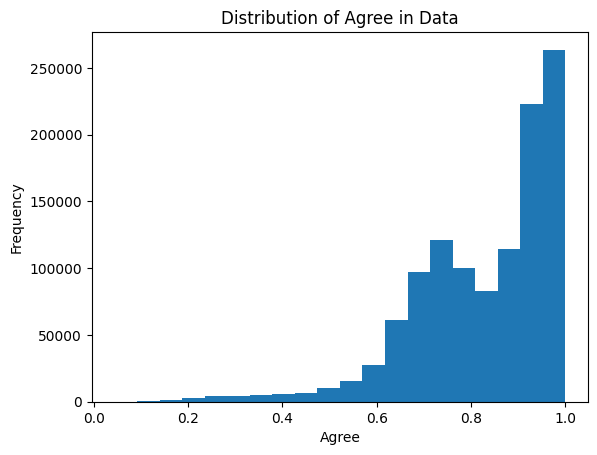

In [29]:
# Plot a histogram of the "agree" feature
plt.hist(data['agree'], bins=20)

# Add labels and a title to the plot
plt.xlabel('Agree')
plt.ylabel('Frequency')
plt.title('Distribution of Agree in Data')

# Display the plot
plt.show()

Text(0.5, 1.0, 'Agreement Scores')

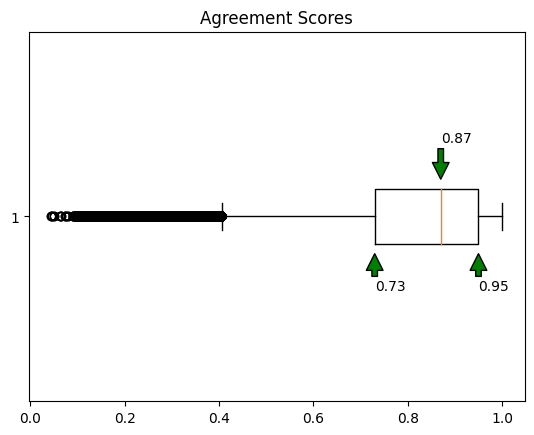

In [30]:
# visualize the distribution of agreement score
plt.boxplot(data['agree'], vert=False)

plt.annotate('0.87', xy =(0.87, 1.1),
                xytext =(0.87, 1.2), 
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.01),)

plt.annotate('0.95', xy =(0.95, 0.9),
                xytext =(0.95, 0.8), 
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.01),)

plt.annotate('0.73', xy =(0.73, 0.9),
                xytext =(0.73, 0.8), 
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.01),)

plt.title("Agreement Scores")

In [31]:
# Exploring outliers
outliers = data.loc[data['agree'] < 0.4]
len(outliers)
outliers_per = len(outliers) / len(data['agree']) * 100
print("Outliers percentage: ", round(outliers_per, 3), '%')

Outliers percentage:  1.718 %


##### Country's voting affinity scores over the years

Generate line plots to show how countries’ voting affinity changes over time.\
The countries we are interested in are the USA, Canada, China, Germany, France, India, Japan, Russia, and the UK.

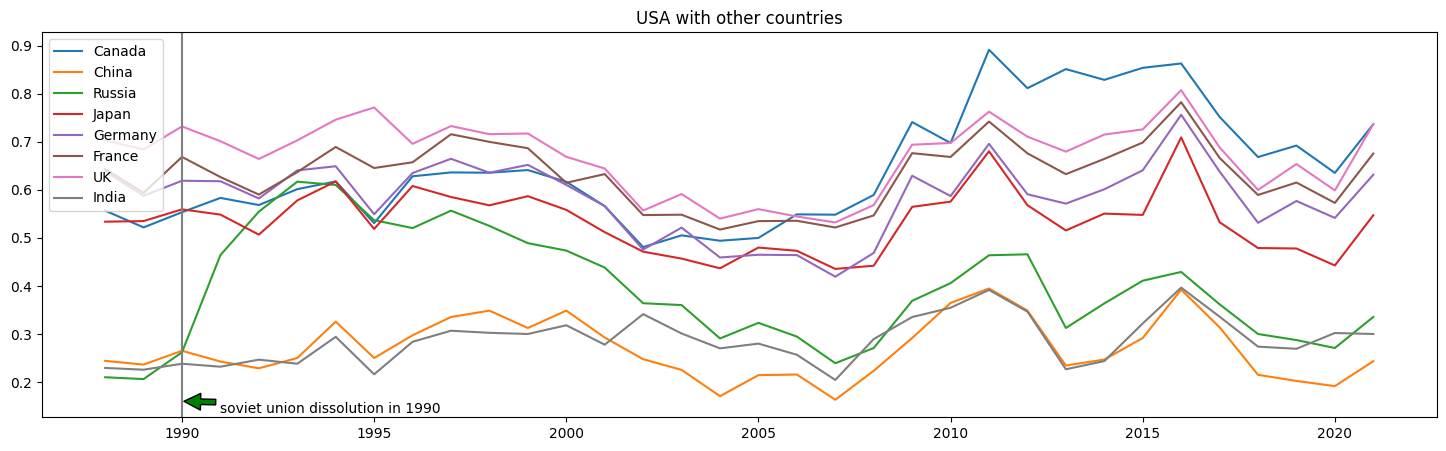

In [32]:
# USA with other countries
fig, ax = plt.subplots(figsize=(18, 5))
x = data.loc[(data['iso1'] == 'USA') & (data['iso2'] == 'CHN'), 'year'].values

# filter data to create the plot
y1 = data.loc[(data['iso1'] == 'USA') & (data['iso2'] == 'CAN'), 'agree'].values
y2 = data.loc[(data['iso1'] == 'USA') & (data['iso2'] == 'CHN'), 'agree'].values
y3 = data.loc[(data['iso1'] == 'USA') & (data['iso2'] == 'RUS'), 'agree'].values
y4 = data.loc[(data['iso1'] == 'USA') & (data['iso2'] == 'JPN'), 'agree'].values
y5 = data.loc[(data['iso1'] == 'USA') & (data['iso2'] == 'DEU'), 'agree'].values
y6 = data.loc[(data['iso1'] == 'USA') & (data['iso2'] == 'FRA'), 'agree'].values
y7 = data.loc[(data['iso1'] == 'USA') & (data['iso2'] == 'GBR'), 'agree'].values
y8 = data.loc[(data['iso1'] == 'USA') & (data['iso2'] == 'IND'), 'agree'].values

# generate line plot 
ax.plot(x, y1, label='Canada')
ax.plot(x, y2, label='China')
ax.plot(x, y3, label='Russia')
ax.plot(x, y4, label='Japan')
ax.plot(x, y5, label='Germany')
ax.plot(x, y6, label='France')
ax.plot(x, y7, label='UK')
ax.plot(x, y8, label='India')
ax.legend(loc='upper left')
plt.title('USA with other countries')

# annotate observation
plt.annotate('soviet union dissolution in 1990', xy =(1990, 0.16),
                xytext =(1991, 0.135), 
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.05),)

plt.axvline(x=1990, color='gray')

Starting from 1990, the affinity score between the US and Russia rose drastically.
Overall, India, China, and Russia show lower scores with the USA compared with other countries.

Text(0.5, 1.0, 'China with other countries')

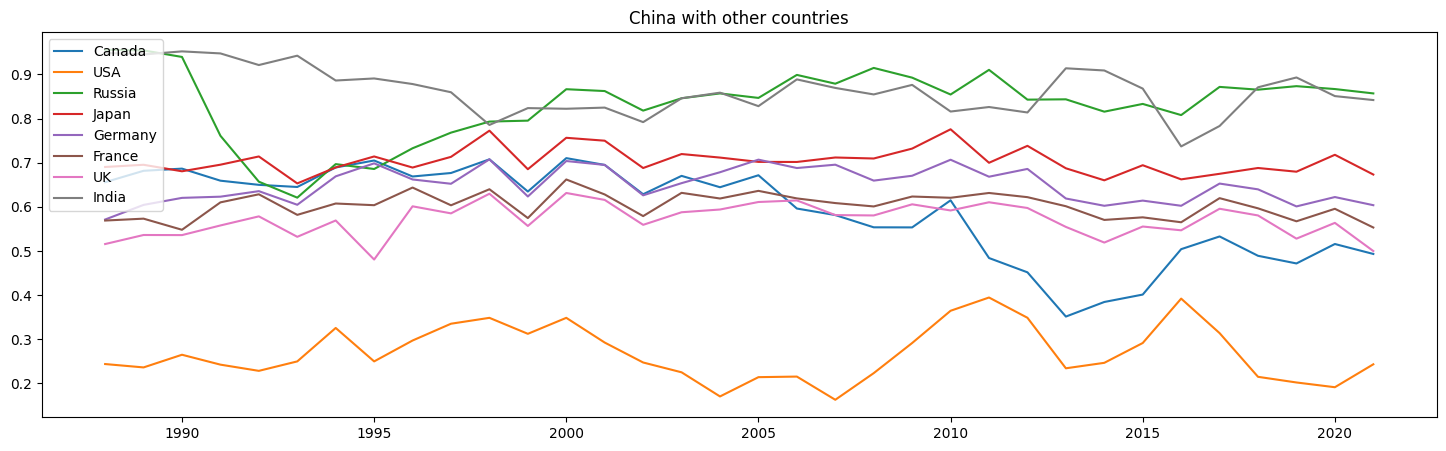

In [33]:
# China with other countries
fig, ax = plt.subplots(figsize=(18, 5))
x = data.loc[(data['iso1'] == 'CHN') & (data['iso2'] == 'USA'), 'year'].values
y1 = data.loc[(data['iso1'] == 'CHN') & (data['iso2'] == 'CAN'), 'agree'].values
y2 = data.loc[(data['iso1'] == 'CHN') & (data['iso2'] == 'USA'), 'agree'].values
y3 = data.loc[(data['iso1'] == 'CHN') & (data['iso2'] == 'RUS'), 'agree'].values
y4 = data.loc[(data['iso1'] == 'CHN') & (data['iso2'] == 'JPN'), 'agree'].values
y5 = data.loc[(data['iso1'] == 'CHN') & (data['iso2'] == 'DEU'), 'agree'].values
y6 = data.loc[(data['iso1'] == 'CHN') & (data['iso2'] == 'FRA'), 'agree'].values
y7 = data.loc[(data['iso1'] == 'CHN') & (data['iso2'] == 'GBR'), 'agree'].values
y8 = data.loc[(data['iso1'] == 'CHN') & (data['iso2'] == 'IND'), 'agree'].values
ax.plot(x, y1, label='Canada')
ax.plot(x, y2, label='USA')
ax.plot(x, y3, label='Russia')
ax.plot(x, y4, label='Japan')
ax.plot(x, y5, label='Germany')
ax.plot(x, y6, label='France')
ax.plot(x, y7, label='UK')
ax.plot(x, y8, label='India')
ax.legend(loc='upper left')
plt.title('China with other countries')

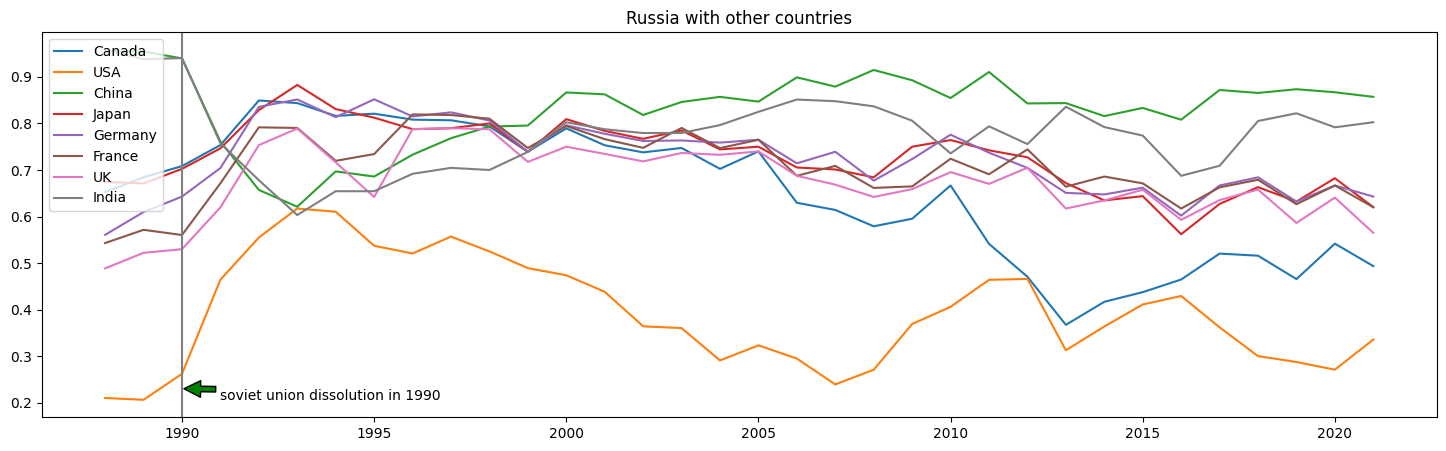

In [34]:
# Russia with other countries
fig, ax = plt.subplots(figsize=(18, 5))
x = data.loc[(data['iso1'] == 'RUS') & (data['iso2'] == 'USA'), 'year'].values
y1 = data.loc[(data['iso1'] == 'RUS') & (data['iso2'] == 'CAN'), 'agree'].values
y2 = data.loc[(data['iso1'] == 'RUS') & (data['iso2'] == 'USA'), 'agree'].values
y3 = data.loc[(data['iso1'] == 'RUS') & (data['iso2'] == 'CHN'), 'agree'].values
y4 = data.loc[(data['iso1'] == 'RUS') & (data['iso2'] == 'JPN'), 'agree'].values
y5 = data.loc[(data['iso1'] == 'RUS') & (data['iso2'] == 'DEU'), 'agree'].values
y6 = data.loc[(data['iso1'] == 'RUS') & (data['iso2'] == 'FRA'), 'agree'].values
y7 = data.loc[(data['iso1'] == 'RUS') & (data['iso2'] == 'GBR'), 'agree'].values
y8 = data.loc[(data['iso1'] == 'RUS') & (data['iso2'] == 'IND'), 'agree'].values
ax.plot(x, y1, label='Canada')
ax.plot(x, y2, label='USA')
ax.plot(x, y3, label='China')
ax.plot(x, y4, label='Japan')
ax.plot(x, y5, label='Germany')
ax.plot(x, y6, label='France')
ax.plot(x, y7, label='UK')
ax.plot(x, y8, label='India')
ax.legend(loc='upper left')
plt.title('Russia with other countries')

plt.annotate('soviet union dissolution in 1990', xy =(1990, 0.23),
                xytext =(1991, 0.205), 
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.05),)

plt.axvline(x=1990, color='gray')

Similar with the previous observation, Russia shares a relatively low affinity score with Canada and USA, while it shows a similar voting trend with China and India.

Text(0.5, 1.0, 'India with other countries')

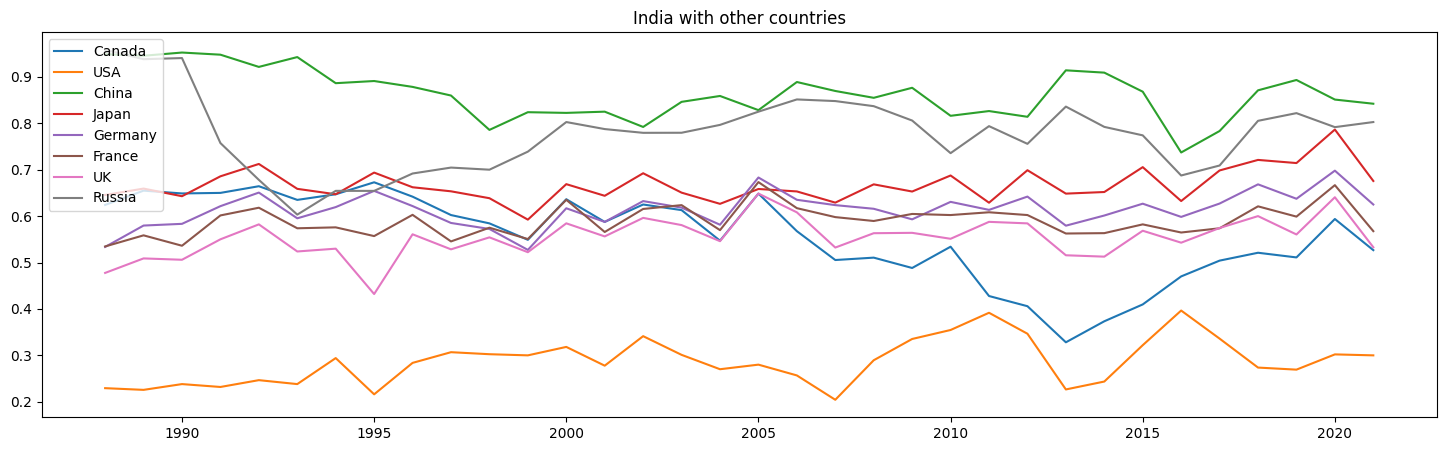

In [35]:
# India with other countries
fig, ax = plt.subplots(figsize=(18, 5))
x = data.loc[(data['iso1'] == 'IND') & (data['iso2'] == 'USA'), 'year'].values
y1 = data.loc[(data['iso1'] == 'IND') & (data['iso2'] == 'CAN'), 'agree'].values
y2 = data.loc[(data['iso1'] == 'IND') & (data['iso2'] == 'USA'), 'agree'].values
y3 = data.loc[(data['iso1'] == 'IND') & (data['iso2'] == 'CHN'), 'agree'].values
y4 = data.loc[(data['iso1'] == 'IND') & (data['iso2'] == 'JPN'), 'agree'].values
y5 = data.loc[(data['iso1'] == 'IND') & (data['iso2'] == 'DEU'), 'agree'].values
y6 = data.loc[(data['iso1'] == 'IND') & (data['iso2'] == 'FRA'), 'agree'].values
y7 = data.loc[(data['iso1'] == 'IND') & (data['iso2'] == 'GBR'), 'agree'].values
y8 = data.loc[(data['iso1'] == 'IND') & (data['iso2'] == 'RUS'), 'agree'].values

ax.plot(x, y1, label='Canada')
ax.plot(x, y2, label='USA')
ax.plot(x, y3, label='China')
ax.plot(x, y4, label='Japan')
ax.plot(x, y5, label='Germany')
ax.plot(x, y6, label='France')
ax.plot(x, y7, label='UK')
ax.plot(x, y8, label='Russia')

ax.legend(loc='upper left')
plt.title('India with other countries')

Text(0.5, 1.0, 'Japan with other countries')

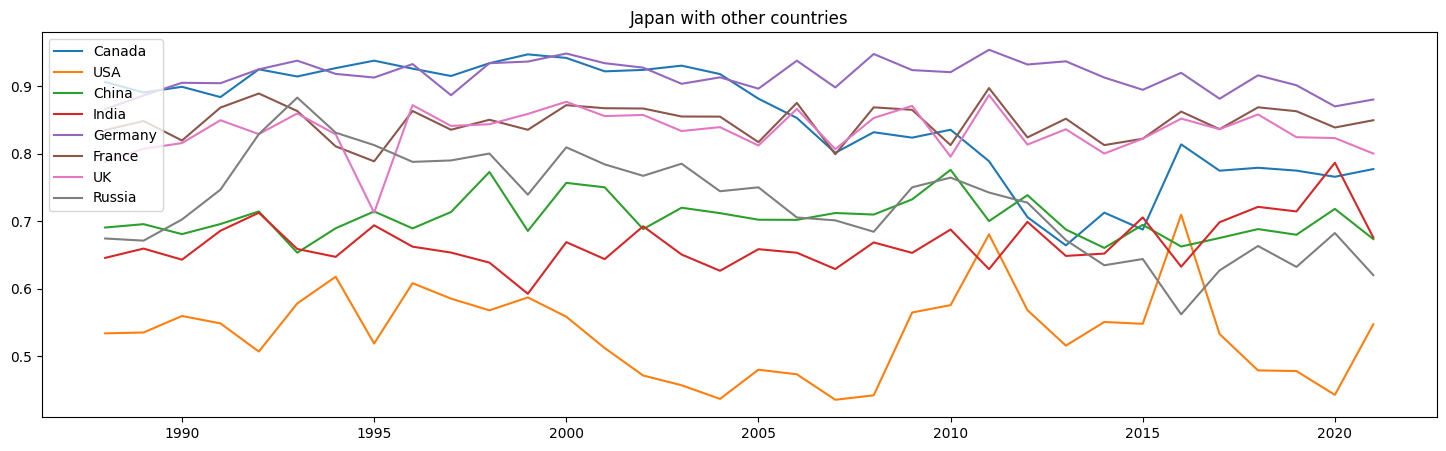

In [36]:
# Japan with other countries
fig, ax = plt.subplots(figsize=(18, 5))
x = data.loc[(data['iso1'] == 'JPN') & (data['iso2'] == 'USA'), 'year'].values
y1 = data.loc[(data['iso1'] == 'JPN') & (data['iso2'] == 'CAN'), 'agree'].values
y2 = data.loc[(data['iso1'] == 'JPN') & (data['iso2'] == 'USA'), 'agree'].values
y3 = data.loc[(data['iso1'] == 'JPN') & (data['iso2'] == 'CHN'), 'agree'].values
y4 = data.loc[(data['iso1'] == 'JPN') & (data['iso2'] == 'IND'), 'agree'].values
y5 = data.loc[(data['iso1'] == 'JPN') & (data['iso2'] == 'DEU'), 'agree'].values
y6 = data.loc[(data['iso1'] == 'JPN') & (data['iso2'] == 'FRA'), 'agree'].values
y7 = data.loc[(data['iso1'] == 'JPN') & (data['iso2'] == 'GBR'), 'agree'].values
y8 = data.loc[(data['iso1'] == 'JPN') & (data['iso2'] == 'RUS'), 'agree'].values

ax.plot(x, y1, label='Canada')
ax.plot(x, y2, label='USA')
ax.plot(x, y3, label='China')
ax.plot(x, y4, label='India')
ax.plot(x, y5, label='Germany')
ax.plot(x, y6, label='France')
ax.plot(x, y7, label='UK')
ax.plot(x, y8, label='Russia')

ax.legend(loc='upper left')
plt.title('Japan with other countries')

Even though China has the lowest affinity score in this plot, the score between Japan and China is higher than China with other Western countries. Overall, Japan's voting affitiny with other countries is relatively higher (>0.5)

European countries show a highly aligned voting affinity.

#### Trade Value

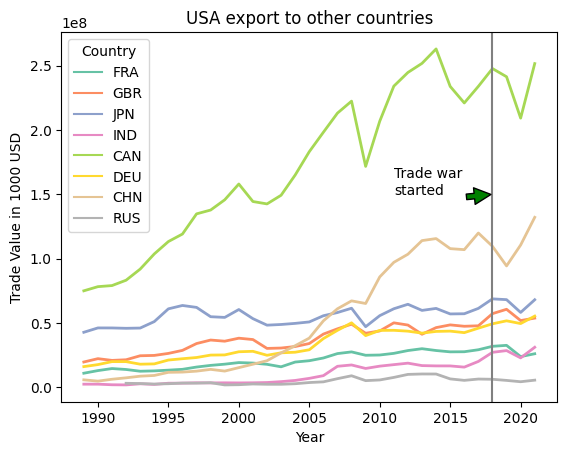

In [37]:
# USA with other countries

# filter data for required countries
usa_trade_data = trade_data[(trade_data['ReporterISO3'] == 'USA') & 
                  (trade_data['PartnerISO3'].isin(['CAN', 'CHN', 'JPN', 'DEU', 'FRA', 'GBR', 'IND', 'RUS']))]

# create a line plot
sns.lineplot(data=usa_trade_data, x='Year', y='TradeValue', hue='PartnerISO3', lw=2, palette='Set2')

# add title and labels
plt.title('USA export to other countries')
plt.xlabel('Year')
plt.ylabel('Trade Value in 1000 USD')
plt.legend(title='Country')

# annotation
plt.annotate('Trade war\nstarted', xy =(2018, 150000000),
                xytext =(2011, 150000000), 
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.05),)

plt.axvline(x=2018, color='gray')


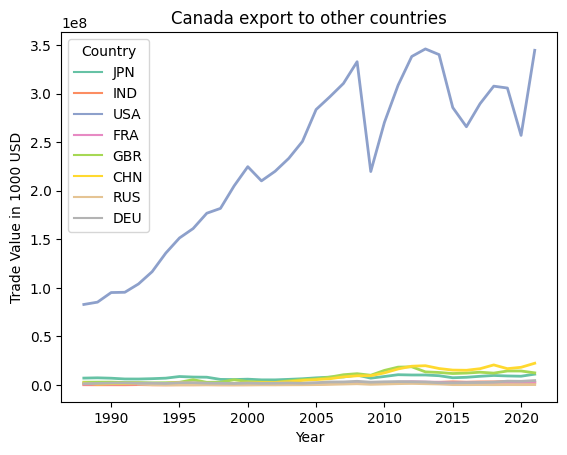

In [38]:
# Canada with other countries
canada_trade_data = trade_data[(trade_data['ReporterISO3'] == 'CAN') &
                    (trade_data['PartnerISO3'].isin(['USA', 'CHN', 'JPN', 'DEU', 'FRA', 'GBR', 'IND', 'RUS']))]
sns.lineplot(data=canada_trade_data, x='Year', y='TradeValue', hue='PartnerISO3', lw=2, palette='Set2', markers=True)
plt.title('Canada export to other countries')
plt.xlabel('Year')
plt.ylabel('Trade Value in 1000 USD')
plt.legend(title='Country')

Canada's export is highly dependent on the USA, making other data unreadable.

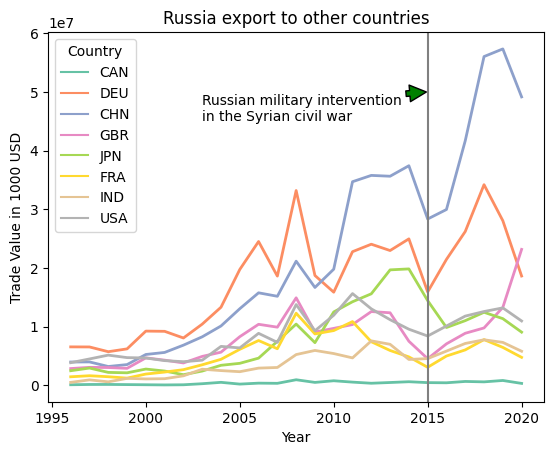

In [39]:
# Russia with other countries
russia_trade_data = trade_data[(trade_data['ReporterISO3'] == 'RUS') &
                    (trade_data['PartnerISO3'].isin(['USA', 'CHN', 'JPN', 'DEU', 'FRA', 'GBR', 'IND', 'CAN']))]
sns.lineplot(data=russia_trade_data, x='Year', y='TradeValue', hue='PartnerISO3', lw=2, palette='Set2', markers=True)
plt.title('Russia export to other countries')
plt.xlabel('Year')
plt.ylabel('Trade Value in 1000 USD')
plt.legend(title='Country')

# annotation
plt.annotate('Russian military intervention\nin the Syrian civil war', xy =(2015, 50000000),
                xytext =(2003, 45000000), 
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.05),)

plt.axvline(x=2015, color='gray')

Over the years, Russia's export relies on China more

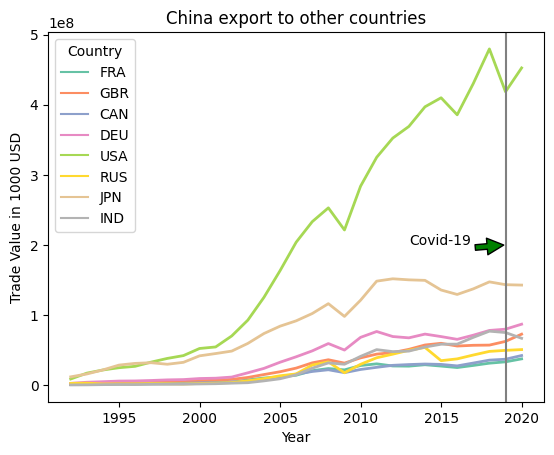

In [40]:
# China with other countries
china_trade_data = trade_data[(trade_data['ReporterISO3'] == 'CHN') &
                    (trade_data['PartnerISO3'].isin(['USA', 'CAN', 'JPN', 'DEU', 'FRA', 'GBR', 'IND', 'RUS']))]
sns.lineplot(data=china_trade_data, x='Year', y='TradeValue', hue='PartnerISO3', lw=2, palette='Set2', markers=True)
plt.title('China export to other countries')
plt.xlabel('Year')
plt.ylabel('Trade Value in 1000 USD')
plt.legend(title='Country')

# annotation
plt.annotate('Covid-19', xy =(2019, 200000000),
                xytext =(2013, 200000000), 
                arrowprops = dict(facecolor ='green',
                                  shrink = 0.05),)

plt.axvline(x=2019, color='gray')


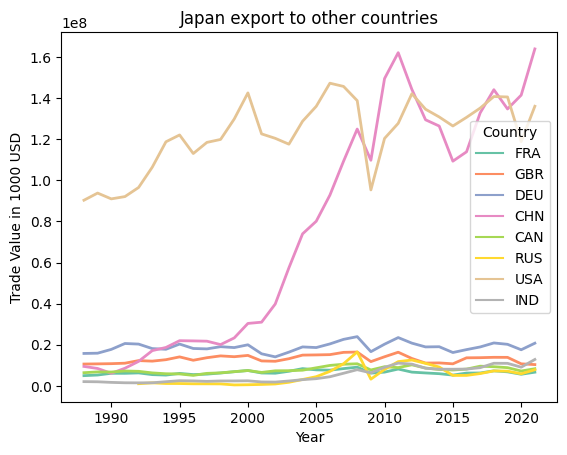

In [41]:
# Japan with other countries
japan_trade_data = trade_data[(trade_data['ReporterISO3'] == 'JPN') &
                    (trade_data['PartnerISO3'].isin(['USA', 'CHN', 'CAN', 'DEU', 'FRA', 'GBR', 'IND', 'RUS']))]
sns.lineplot(data=japan_trade_data, x='Year', y='TradeValue', hue='PartnerISO3', lw=2, palette='Set2', markers=True)
plt.title('Japan export to other countries')
plt.xlabel('Year')
plt.ylabel('Trade Value in 1000 USD')
plt.legend(title='Country')

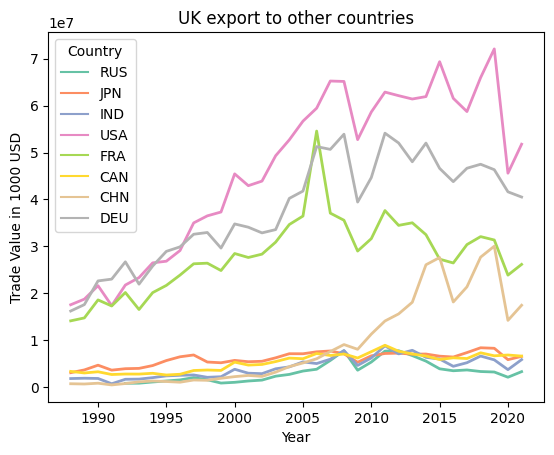

In [42]:
# UK with other countries
uk_trade_data = trade_data[(trade_data['ReporterISO3'] == 'GBR') &
                    (trade_data['PartnerISO3'].isin(['USA', 'CHN', 'JPN', 'DEU', 'FRA', 'CAN', 'IND', 'RUS']))]
sns.lineplot(data=uk_trade_data, x='Year', y='TradeValue', hue='PartnerISO3', lw=2, palette='Set2', markers=True)
plt.title('UK export to other countries')
plt.xlabel('Year')
plt.ylabel('Trade Value in 1000 USD')
plt.legend(title='Country')


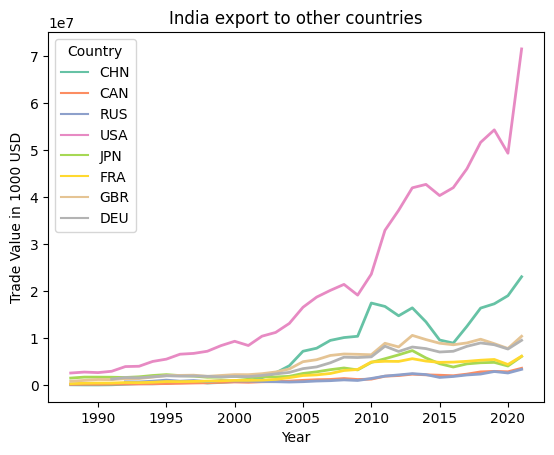

In [43]:
# India with other countries
india_trade_data = trade_data[(trade_data['ReporterISO3'] == 'IND') &
                    (trade_data['PartnerISO3'].isin(['USA', 'CHN', 'JPN', 'DEU', 'FRA', 'GBR', 'CAN', 'RUS']))]
sns.lineplot(data=india_trade_data, x='Year', y='TradeValue', hue='PartnerISO3', lw=2, palette='Set2', markers=True)
plt.title('India export to other countries')
plt.xlabel('Year')
plt.ylabel('Trade Value in 1000 USD')
plt.legend(title='Country')

India actually exports more good to USA than to China.

##### Country Similarity

<AxesSubplot:>

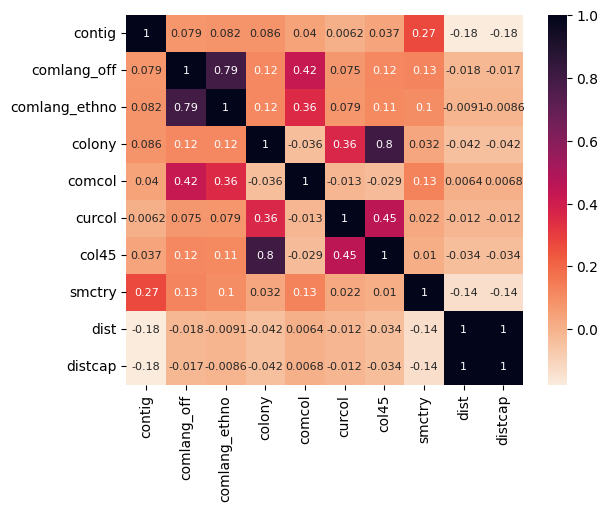

In [44]:
corre = country_similarity.corr()
sns.heatmap(corre, annot=True, annot_kws={"size": 8}, cmap = sns.color_palette("rocket_r", as_cmap=True))

## Analysis

### Panel Data Regression with Time-Fixed Effects

In [45]:
# Re-read the "agreement_scores_with_iso" from the local exported file
agreement = pd.read_csv('agreement_scores_with_iso.csv')
agreement.head(5)

,Unnamed: 0,Unnamed: 0.1,session.x,ccode1,ccode2,agree,year,IdealPointAll.x,NVotesAll.x,IdealPointAll.y,NVotesAll.y,IdealPointDistance,iso1,iso2
0,581026,581027,43,2,20,0.556818,1988,3.079959,133.0,1.585116,133.0,1.494843,USA,CAN
1,581027,581028,43,2,31,0.268000,1988,3.079959,133.0,0.223987,128.0,2.855972,USA,BHS
2,581028,581029,43,2,40,0.206767,1988,3.079959,133.0,-1.352824,135.0,4.432783,USA,CUB
3,581029,581030,43,2,41,0.260163,1988,3.079959,133.0,-0.039816,126.0,3.119775,USA,HTI
4,581030,581031,43,2,42,0.274590,1988,3.079959,133.0,0.287246,125.0,2.792713,USA,DOM


In [46]:
# SQL query to join agreement_scores_with_iso, trade_final, and country_similarity dataframes
query_reg_table = '''
    SELECT
        A.iso1 AS ISO1,
        A.iso2 AS ISO2,
        A.Year AS Year,
        A.agree AS Agree,
        A.IdealPointDistance,
        T.Exp_Pct_Avg,
        S.contig,
        S.comlang_off,
        S.comlang_ethno,
        S.colony,
        S.comcol,
        S.curcol,
        S.smctry
    FROM
        agreement AS A
    INNER JOIN
        trade_final AS T
    ON
        (A.iso1 = T.ReporterISO3) AND
        (A.iso2 = T.PartnerISO3) AND
        (A.Year = T.Year)
    INNER JOIN
        country_similarity as S
    ON
        (A.iso1 = S.iso_o) AND
        (A.iso2 = S.iso_d)
'''


In [47]:
# Executing the SQL query to join dataframes and storing the result in reg_table
reg_table = pysqldf(query_reg_table)

# Displaying the first few rows of reg_table
reg_table.head()

,ISO1,ISO2,Year,Agree,IdealPointDistance,Exp_Pct_Avg,contig,comlang_off,comlang_ethno,colony,comcol,curcol,smctry
0,CAN,USA,1988,0.556818,1.494843,0.000000,1,1,1,0,0,0,0
1,CAN,BHS,1988,0.692000,1.361129,0.000000,0,1,1,0,0,0,0
2,CAN,CUB,1988,0.609023,2.937940,0.000000,0,0,0,0,0,0,0
3,CAN,HTI,1988,0.693548,1.624932,0.006739,0,1,0,0,0,0,0
4,CAN,DOM,1988,0.692623,1.297870,0.000000,0,0,0,0,0,0,0


In [48]:
# Creating lagged variables for the agreement scores (1-3 periods)
reg_table['Agree_Lag1'] = reg_table['Agree'].shift(1)
reg_table['Agree_Lag2'] = reg_table['Agree'].shift(2)
reg_table['Agree_Lag3'] = reg_table['Agree'].shift(3)

In [49]:
# Creating a new column 'Country_Pair' by concatenating 'ISO1' and 'ISO2' columns
reg_table['Country_Pair'] = reg_table['ISO1'] + '_' + reg_table['ISO2']

# Dropping rows with missing values
reg_table.dropna(inplace=True)

# Set index as country pair and year
reg_table.set_index(['Country_Pair', 'Year'], inplace=True)

In [50]:
# Defining the features (X) and target variable (y) for the regression model
X = reg_table[['Agree_Lag1', 'Agree_Lag2', 'Agree_Lag3', 'Exp_Pct_Avg', 'IdealPointDistance', 'contig', \
'comlang_off', 'comlang_ethno', 'comcol']]
y = reg_table['Agree']

# Fit PanelOLS with fixed effects and using clustered covariance estimator
model = PanelOLS(y, X, entity_effects=False, time_effects=True)
results = model.fit(cov_type='clustered', cluster_entity=True)

# Printing the model summary
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  Agree   R-squared:                        0.8172
Estimator:                   PanelOLS   R-squared (Between):              0.2491
No. Observations:              501763   R-squared (Within):               0.2598
Date:                Thu, Apr 27 2023   R-squared (Overall):              0.2254
Time:                        17:04:08   Log-likelihood                 6.724e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   2.493e+05
Entities:                       27362   P-value                           0.0000
Avg Obs:                       18.338   Distribution:                F(9,501720)
Min Obs:                       1.0000                                           
Max Obs:                       34.000   F-statistic (robust):          1.502e+04
                            